### Library Imports

In [56]:
# Standard libraries
import os
import json
import time

# Data handling
import pandas as pd
import numpy as np

# Prediction guard and language models
from predictionguard import PredictionGuard
from langchain.prompts import PromptTemplate, FewShotPromptTemplate

# Torch and Skorch
import torch
from torch import nn
from torch.optim import Adam
from skorch import NeuralNetClassifier

# Transformers (for embeddings)
from transformers import BertTokenizer, BertModel

# Machine learning models and utilities
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Metrics and performance evaluation
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    f1_score
)

# Plotting
import matplotlib.pyplot as plt

# XGBoost
from xgboost import XGBClassifier

# Imbalanced-learn for oversampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Surpress Warnings
import warnings
warnings.filterwarnings("ignore")

## Data Import

In [45]:
# Meta Model Data (True Labels)
examples_df = pd.read_csv('examples.csv', index_col=False)

# Test Data
test_df = pd.read_csv('test.csv', index_col=False)

# Synthetic Numerical Data
augmented = pd.read_csv('AugmentedData.csv', index_col=False)
sexybigrams = pd.read_csv('Sexybigrams.csv', index_col=False)
surpriseme = pd.read_csv('surprisemebrother_60.csv', index_col=False)

# Synthetic Free-Response Data
jomama = pd.read_csv('jomama.csv', index_col=False)

## Preprocessing

In [46]:
# Column Select
numerical_columns = [f'q{i}' for i in range(1, 21)]
embedding_columns = [f'q{i}' for i in range(21, 23)]
numerical_columns_label = [f'q{i}' for i in range(1, 21)] + ['label']
embedding_columns_label = [f'q{i}' for i in range(21, 23)] + ['label']

# Numerical Training Data Concatenation
numerical_train = pd.concat([augmented[numerical_columns_label], sexybigrams[numerical_columns_label], surpriseme[numerical_columns_label]])

# Embedding Training Data Concatenation
embedding_train = jomama.drop('Id', axis = 1)

# Numerical Meta-Model Data 
examples_num = examples_df[numerical_columns_label]

# Embeddings Meta-Model Data
examples_embed = examples_df[embedding_columns_label]

# Numerical Test Data
test_num = test_df[numerical_columns]

# Embeddings Test Data 
test_embed = test_df[embedding_columns]

### Numerical Preprocessing

In [47]:
# Turning Non-Numerical Data to NaN
numerical_train = numerical_train.apply(pd.to_numeric, errors='coerce')
examples_num = examples_num.apply(pd.to_numeric, errors='coerce')
test_num = test_num.apply(pd.to_numeric, errors='coerce')

In [48]:
# Replace NaN Values with Mean
for col in numerical_columns:
    mean_val = numerical_train[col].mean()
    numerical_train[col].fillna(mean_val, inplace = True) 
    numerical_train[col] = numerical_train[col].round().astype(float)

for col in numerical_columns:
    mean_val = examples_num[col].mean()
    examples_num[col].fillna(mean_val, inplace = True) 
    examples_num[col] = examples_num[col].round().astype(float)

for col in numerical_columns:
    mean_val = test_num[col].mean()
    test_num[col].fillna(mean_val, inplace = True) 
    test_num[col] = test_num[col].round().astype(float)

### Embedding Preprocessing

In [51]:
# Initialize Transformer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

In [52]:
# Define Function to Apply Embeddings
def get_embedding(text):
    # Tokenize Input Text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    
    # Get Token Embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        token_embeddings = outputs.last_hidden_state
        attention_mask = inputs['attention_mask']
        
        # Mean Pooling
        mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        mean_pooled_embedding = sum_embeddings / sum_mask
    
    return mean_pooled_embedding.squeeze().numpy()

In [54]:
# Apply Embeddings
embedding_train['q21embedded'] = embedding_train['q21'].astype(str).apply(get_embedding)
embedding_train['q22embedded'] = embedding_train['q22'].astype(str).apply(get_embedding)

examples_embed['q21embedded'] = examples_embed['q21'].astype(str).apply(get_embedding)
examples_embed['q22embedded'] = examples_embed['q22'].astype(str).apply(get_embedding)

test_embed['q21embedded'] = test_embed['q21'].astype(str).apply(get_embedding)
test_embed['q22embedded'] = test_embed['q22'].astype(str).apply(get_embedding)

In [101]:
# Concatenate Embeddings
embedding_train['combined_embedding'] = embedding_train.apply(lambda row: np.concatenate([row['q21embedded'], row['q22embedded']]), axis=1)
examples_embed['combined_embedding'] = examples_embed.apply(lambda row: np.concatenate([row['q21embedded'], row['q22embedded']]), axis=1)
test_embed['combined_embedding'] = test_embed.apply(lambda row: np.concatenate([row['q21embedded'], row['q22embedded']]), axis=1)

### Label Preprocessing

In [49]:
# Scaling Labels Between 0, ..., 6
numerical_train['label'] -= 1

embedding_train['label'] -= 1

examples_num['label'] -= 1

examples_embed['label'] -= 1

## Numerical Model Training

In [80]:
# Train and Test Splitting

# Base Model Training Data
X_train_num = numerical_train.drop('label', axis=1)
Y_train_num = numerical_train['label']

# Meta-Model Training Data
X_examples_num = examples_num.drop('label', axis=1)
Y_examples_num = examples_num['label']

# Test Data
X_test_num = test_num
X_test_num = X_test_num.to_numpy()

In [65]:
# Parameter grids for each model
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Parameter grid for the Decision Tree
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [66]:
# Base Models
# Random Forest
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=0)
grid_search_rf.fit(X_train_num, Y_train_num)
print("Best RF parameters:", grid_search_rf.best_params_)
print("Best RF F1:", grid_search_rf.best_score_)

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=0)
grid_search_gb.fit(X_train_num, Y_train_num)
print("Best GB parameters:", grid_search_gb.best_params_)
print("Best GB F1:", grid_search_gb.best_score_)

# Support Vector Classifier
svc = SVC(probability=True, random_state=42)
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid_svc, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=0)
grid_search_svc.fit(X_train_num, Y_train_num)
print("Best SVC parameters:", grid_search_svc.best_params_)
print("Best SVC F1:", grid_search_svc.best_score_)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=0)
grid_search_dt.fit(X_train_num, Y_train_num)
print("Best DT parameters:", grid_search_dt.best_params_)
print("Best DT F1:", grid_search_dt.best_score_)

Best RF parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
Best RF F1: 0.8524634205939108
Best GB parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best GB F1: 0.8530096105265276
Best SVC parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVC F1: 0.8497656328401042
Best DT parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best DT F1: 0.8384883845395013


In [67]:
# Neural Network Base Model
class MyModule(nn.Module):
    def __init__(self, inp_size, hidden_sizes, num_classes=6, nonlin=nn.ReLU()):
        super().__init__()
        self.hidden = nn.ModuleList()
        input_layer = nn.Linear(inp_size, hidden_sizes[0])
        self.hidden.append(input_layer)
        self.hidden.append(nonlin)

        for i in range(len(hidden_sizes) - 1):
            layer = nn.Linear(hidden_sizes[i], hidden_sizes[i+1])
            self.hidden.append(layer)
            self.hidden.append(nonlin)

        self.output = nn.Linear(hidden_sizes[-1], num_classes)

        self.softmax = nn.Softmax(dim = 1)

    def forward(self, X):
        for layer in self.hidden:
            X= X.float()
            X = layer(X)

        X = self.output(X)

        out = self.softmax(X)

        return out

In [68]:
# Neural Network Base Model Definition
net = NeuralNetClassifier(
    MyModule, 
    module__inp_size=X_train_num.shape[1],
    max_epochs = 20,
    lr = 0.01,
    batch_size = 256,
    optimizer = Adam, 
    criterion = nn.CrossEntropyLoss,
    iterator_train__shuffle = True
    
)

net.set_params(train_split=False, verbose=0)

params = {
    'lr': [0.1, 0.2, 0.01], 
    'max_epochs': [100],      
    'batch_size': [32, 64, 128, 256],  
    'module__hidden_sizes': [
        [256, 128, 64, 32, 16],
    ], 
    'module__nonlin': [nn.ReLU(), nn.Tanh(), nn.LeakyReLU(), nn.Sigmoid()] 
}

gs = GridSearchCV(
    net, 
    params, 
    cv = 5, 
    scoring = 'f1_weighted',
    refit = True
)

In [69]:
# Neural Network Training
X_train_nn = X_train_num.to_numpy()
y_train_nn = Y_train_num.to_numpy()

gs.fit(X_train_nn, y_train_nn)

GridSearchCV(cv=5,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.MyModule'>,
  module__inp_size=20,
),
             param_grid={'batch_size': [32, 64, 128, 256],
                         'lr': [0.1, 0.2, 0.01], 'max_epochs': [100],
                         'module__hidden_sizes': [[256, 128, 64, 32, 16]],
                         'module__nonlin': [ReLU(), Tanh(),
                                            LeakyReLU(negative_slope=0.01),
                                            Sigmoid()]},
             scoring='f1_weighted')

In [70]:
# Extracting Best Models
best_rf = grid_search_rf.best_estimator_
best_gb = grid_search_gb.best_estimator_
best_svc = grid_search_svc.best_estimator_
best_dt = grid_search_dt.best_estimator_
best_nn = gs.best_estimator_

In [87]:
# Meta Model Training
X_meta = X_examples_num.to_numpy()
y_meta = Y_examples_num.to_numpy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

stacking_model = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=2)),
    ('stack', StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('gb', best_gb),
        ('svc', best_svc),
        ('dt', best_dt),
        ('nn', best_nn)
    ],
    final_estimator=RandomForestClassifier(),
    cv=5
))
])

for train_index, val_index in kf.split(X_meta):
    X_meta_train, X_meta_val = X_meta[train_index], X_meta[val_index]
    y_meta_train, y_meta_val = y_meta[train_index], y_meta[val_index]
    
    # Train stacked model on each fold
    stacking_model.fit(X_meta_train, y_meta_train)
    
    # Predict and evaluate
    y_pred = stacking_model.predict(X_meta_val)
    f1 = f1_score(y_meta_val, y_pred, average='weighted')
    f1_scores.append(f1)

In [88]:
# Numerical Model Predictions 
y_proba_num = stacking_model.predict_proba(X_test_num)[:, 1]
y_pred_num = stacking_model.predict(X_test_num)

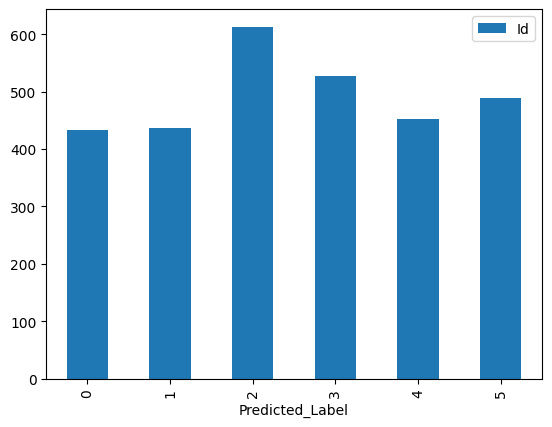

In [89]:
# Plot Class Distributions
predictions_num = pd.DataFrame({'Id': test_df['Id'], 'Predicted_Label': y_pred_num})
predictions_num.groupby('Predicted_Label').count().plot(kind='bar')
plt.show()

## Embedding Model Training

In [126]:
# Train and Test Splitting

# Base Model Training Data
X_train_embed = np.stack(embedding_train['combined_embedding'].values)
Y_train_embed = embedding_train['label']

# Meta-Model Training Data
X_examples_embed = np.stack(examples_embed['combined_embedding'].values)
Y_examples_embed = examples_embed['label']

# Test Data
X_test_embed = np.stack(test_embed['combined_embedding'].values)